### Введение
#### Предподгатовка входных данных:
###### Напомню под растоянием между скважинами здесь и далее я имею в виду DTW меру растояния от одного временного ряда до другого.
###### Первоначальная идея с расчетом растояний от каждой скважины до каждой провалилась, т.к. требовала слишком много времени (напомню речь идет о 32 тысячах скважин = пар временных рядов (по 2 ряда на скважину)).
###### Поэтому я решил выбрать характерные скважины и посчитать растояние от них до каждой скважины (всего не более 700 скважин) таким образом сильно сократив время расчетов. Скважины выбирались псевдо оптимально (сначала внутри каждого класса выберались претенденты (на основании матрицы растояний внутри класса) а потом все претенденты собирались в опщий список).
###### Кроме того для наполнения классов со слишком малым количеством элементов была пременена аугментация (сдвиг, сжатие/растяжение , и добавление к значениям временных рядов малой константы (5% от амплитуды)). В результате сильно не сбалансированный исходынй датасет (~23000 скв.) получился более менее сбалансированный (~32000 скв.).
###### Таким образом на вход алгоритма подается массив данных из растояний от выбранных характерных скважин до всех остальных для первого типа каротажа и для второго (эти столбцы называются WL1_*№* и WL2_*№*, где *№* - номер характерной скважины. Кроме того есть столбцы типа FE_*№* и mrk_*№* - это дополнительные данные по каждой скважине (FE_*№* - нормированные оценки некоторых свойств пласта) (mrk_*№* - логическая матрица(0,1) описывающая пренадлежность скважины конкретному пласту (имеет такой вид потому что была получена из строковой переменной имени пласта)). Так же в присутствует специальный столбец val_idx - это индекс пренадлежности к валидационной выборке, т.е. контрольную выборку для финальной вылидации я заранее выделил сам она состовляет 15% от всех данных и в нее вошли только не аугментированные данные (а так же эти данные сами не являлись родительскими для аугментации).
###### Для упрощения проверки есть два датасета полный (32000 строк с 36 классами) и короткий (120 строк с 3 классами). Короткий датасет был получен из полного и в нем все классы сбалансированы (равны по численности), в полном это не так.
#### Метрики качества:
###### Для оченки качества модели я рассматриваю две метрики: f1-меру и среднюю вероятность правильного угадывания.
###### f1-мера модифицирована и расчитывается для каждого класса в отдельности, при этом вместо суммы точных ответов (единиц) используются вероятности соответствующих ответов. Это сделало матрику более чувствительной. Так как мне выжно создать алгоритм точно определяющий каждый из представленных классов, я так же вывожу на экран графики f1-меры со значениями по каждому классу.
###### Cреднюю вероятность правильного угадывания расчитывается как среднее от всех вероятностей правильных ответов.

### Загрузка библиотек

In [13]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt

### Чтение данных

In [2]:
flag_short_data=1
if flag_short_data: # Малый DataSet (пример для тестирования и обзора алгоритма)
    dat=pd.read_csv('01_input//stp04_shortDataSet_MXcc_dat.csv', sep = ';')
else: # Полный DataSet (для итогового расчера)
    dat=pd.read_csv('01_input//stp04_MXcc_dat.csv', sep = ';')
n_class=int(dat.values[:,0].max())

### Разбиваем исходные данные по подвыборкам

In [3]:
# Массив с номером класса
dat_class=dat.values[:,0]

# Выделим столбцы с FE
flag_fe=np.zeros(dat.shape[1])
for i in range(dat.shape[1]):
    if dat.columns[i][0:2] == 'FE':
        flag_fe[i]=1
dat_fe=dat.values[:,flag_fe>0]

# Выделим столбцы с mrk
flag_mrk=np.zeros(dat.shape[1])
for i in range(dat.shape[1]):
    if dat.columns[i][0:3] == 'mrk':
        flag_mrk[i]=1
dat_mrk=dat.values[:,flag_mrk>0]

# Выделим столбцы с WL
flag_wl=np.zeros(dat.shape[1])
for i in range(dat.shape[1]):
    if dat.columns[i][0:3] == 'WL1':
        flag_wl[i]=1
    if dat.columns[i][0:3] == 'WL2':
        flag_wl[i]=2

# Применение МГК для понижения размерности данных WL и исключения их линейной взаимозависимости
pca = PCA(.99) # Постораемся сохранить 99% информации 
buf=dat.values[dat.val_idx==0,:] # Обучаемся на всех данных кроме валидационных
pca.fit(buf[:,flag_wl>0])
dat_wl=pca.transform(dat.values[:,flag_wl>0])
dat_wl.shape

(120, 26)

### Разделяем на обучающую, тренеровочную и валидационную выборки

In [4]:
# Валидационная выборка (для итоговой оценки)
dat_class_val_1=dat_class[dat.val_idx==1]
dat_fe_val_1=dat_fe[dat.val_idx==1,:]
dat_mrk_val_1=dat_mrk[dat.val_idx==1,:]
dat_wl_val_1=dat_wl[dat.val_idx==1,:]
# Остальные данные
dat1_class=dat_class[dat.val_idx==0]
dat1_fe=dat_fe[dat.val_idx==0,:]
dat1_mrk=dat_mrk[dat.val_idx==0,:]
dat1_wl=dat_wl[dat.val_idx==0,:]

In [5]:
# Очистим память от ненужных более переменных
# !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!!
# ВНИМАНИЕ:
#   если после исполнения этого кода вы захотите вернутся
#     к предыдущим шагам, то придется запустить notebook сначала
# !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!! !!!
del dat, dat_class, dat_fe, dat_mrk, dat_wl, buf

In [6]:
# Подготовка выборок "X" и "y" 
y=dat1_class
y_str = [str(x) for x in y]
#X=np.concatenate((dat2_fe,dat2_mrk,dat2_wl),axis=1)
X=np.concatenate((dat1_fe,dat1_mrk,dat1_wl),axis=1)

y_val1=dat_class_val_1
y_val1_str = [str(x) for x in y_val1]
X_val1=np.concatenate((dat_fe_val_1,dat_mrk_val_1,dat_wl_val_1),axis=1)

#y_val2=dat_class_val_2
#y_val2_str = [str(x) for x in y_val2]
#X_val2=np.concatenate((dat_fe_val_2,dat_mrk_val_2,dat_wl_val_2),axis=1)

In [7]:
# Функция расчета f1 меры для каждого класса
def my_f1_score(preds,y_real):
    f1=[]
    for i in range(preds.shape[1]):
        TP=preds[y_real==i,i].sum()# True Positives
        FP=preds[y_real!=i,i].sum()# False Positives
        ix=list(range(preds.shape[1]))
        ix.remove(i)
        buf=preds[:,ix]
        FN=buf[y_real==i,:].sum()# False Negatives
        PR=TP/(TP+FP)#   Precision
        RE=TP/(TP+FN)#   Recall
        f1.append(2*PR*RE/(RE+PR))
    return f1
# Функция расчета средней вероятности правильного определения класса
def mean_prob0(preds,y_real):
    prob_true=[]
    for i in range(preds.shape[0]):
        prob_true.append(preds[i,int(y_real[i])])
    return np.mean(prob_true)
# Функция визуализации результата
def print_rez(preds,y_val1,n_class): 
    num_of_points_per_class=[]
    for i in range(1,n_class+1):
        num_of_points_per_class.append(np.sum(y_val1==i))
    rez4plot=np.array((range(1,n_class+1),my_f1_score(preds,y_val1-1),num_of_points_per_class)).T
    plt.figure(figsize=(14, 6))
    plt.subplot(2,1,1)
    plt.bar(rez4plot[:,0],rez4plot[:,1])
    plt.ylabel('f1-score');
    plt.subplot(2,1,2)
    plt.bar(rez4plot[:,0],rez4plot[:,2],color=list(0.8*np.ones(n_class)),edgecolor='red')
    plt.ylabel('number of points');
    plt.xlabel('№ class');
    plt.show()
    return rez4plot

#### LightGBM

LightGBM (CrossVal):
	f1-score (mean):	0.653
	right probability:	0.6551


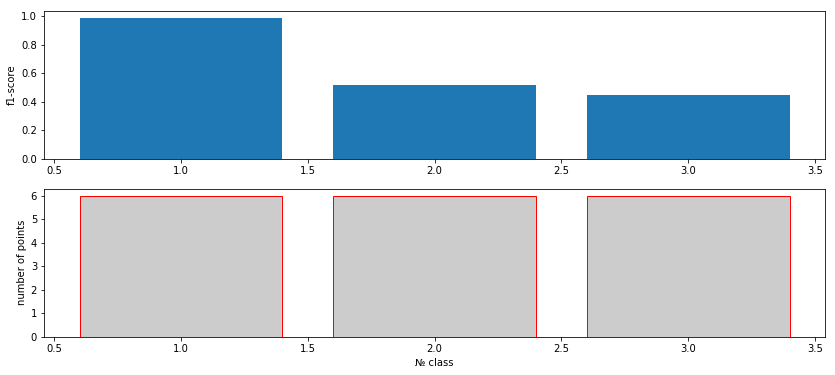

In [8]:
LGB_trn= lgb.Dataset(data = X, label = y-1,feature_name = [str(x) for x in list(range(X.shape[1]))])

params = {'objective': 'multiclass',
          'metric': 'multi_logloss',
          'num_class':n_class}
lgb_cv = lgb.cv( params, LGB_trn,
        num_boost_round=100, nfold=5, early_stopping_rounds=10 )
nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))

clf_f3 = lgb.train(params, LGB_trn, num_boost_round=nround)
preds = clf_f3.predict(X_val1)
print('LightGBM (CrossVal):')
print('\tf1-score (mean):\t' + str(np.mean(my_f1_score(preds,y_val1-1)).round(4)))
print('\tright probability:\t' + str(mean_prob0(preds,y_val1-1).round(4)))
f3_4plot=print_rez(preds,y_val1,n_class)

### Оптимизация параметров моделей

#### RandomForest

RandomizedSearchCV took 29.05 seconds for 200 candidates parameter settings.
RandomForest (CrossVal):
	f1-score (mean):	0.645
	right probability:	0.6517


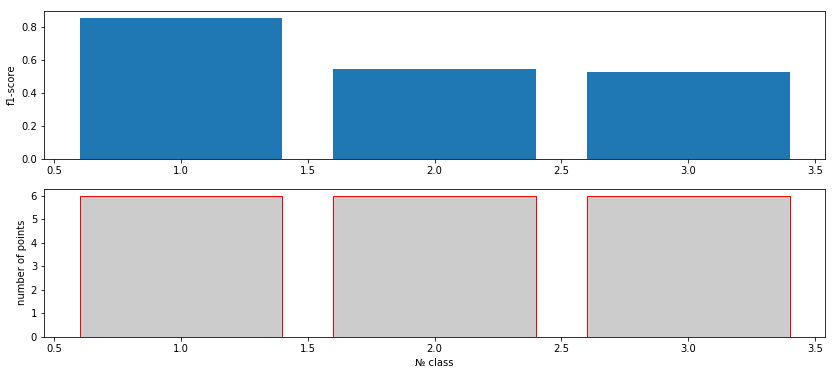

In [9]:
# Подбор оптимальных параметров случайным образом
clf_rf = RandomForestClassifier(criterion='gini')

param_dist = {"n_estimators": list(150+np.array(list(range(0,4)))*50),
              "max_depth": [3, 5, 7, 9],
              "min_samples_split": sp_randint(2+int(0.01*X.shape[0]),int(0.1*X.shape[0])),
              "bootstrap": [True, False]}

n_iter_search = 200
rs_rf= RandomizedSearchCV( clf_rf,n_jobs=5, param_distributions=param_dist,
                                     n_iter=n_iter_search, cv=5, iid=False, random_state=12345)

start = time.time()
rs_rf.fit(X, y-1)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
clf_rf_2=rs_rf.best_estimator_
preds=clf_rf_2.predict_proba(X_val1)
rf_2_score=np.mean([np.mean(my_f1_score(preds,y_val1-1)),mean_prob0(preds,y_val1-1)])
# Применение подобранных параметров
clf_rf_1 = RandomForestClassifier(criterion='gini', bootstrap=rs_rf.best_params_['bootstrap'],
          max_depth=rs_rf.best_params_['max_depth'], min_samples_split=rs_rf.best_params_['min_samples_split'],
           n_estimators=rs_rf.best_params_['n_estimators'], random_state=12345)
clf_rf_1.fit(X, y-1)
preds=clf_rf_1.predict_proba(X_val1)
rf_1_score=np.mean([np.mean(my_f1_score(preds,y_val1-1)),mean_prob0(preds,y_val1-1)])
if rf_1_score>rf_2_score: # Выбор лучшего из двух
    clf_f1=clf_rf_1
else:
    clf_f1=clf_rf_2
print('RandomForest (CrossVal):')
print('\tf1-score (mean):\t' + str(np.mean(my_f1_score(preds,y_val1-1)).round(4)))
print('\tright probability:\t' + str(mean_prob0(preds,y_val1-1).round(4)))
f1_4plot=print_rez(preds,y_val1,n_class)

#### SVC

C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 60 is smaller than n_iter=500. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV took 0.44 seconds for 500 candidates parameter settings.
SVC (CrossVal):
	f1-score (mean):	0.6285
	right probability:	0.6472


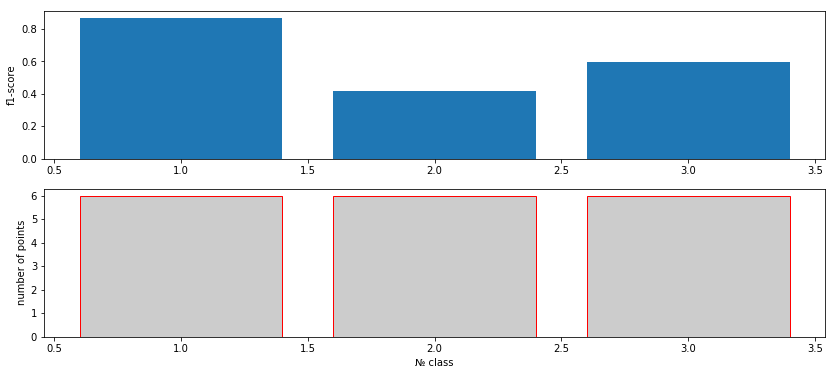

In [10]:
# Подбор оптимальных параметров случайным образом
clf_svm = SVC(probability=True, decision_function_shape='ovo', random_state=12345)

param_dist = {"C": np.arange(2, 10, 2),
            "degree": np.arange(2, 5),
             "gamma": np.arange(0.1, 1, 0.2)}

n_iter_search = 500
rs_svm= RandomizedSearchCV( clf_svm,n_jobs=5, param_distributions=param_dist,
                                     n_iter=n_iter_search, cv=5, iid=False, random_state=12345)
start = time.time()
rs_svm.fit(X, y-1)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
clf_svm_2=rs_svm.best_estimator_
preds=clf_svm_2.predict_proba(X_val1)
svm_2_score=np.mean([np.mean(my_f1_score(preds,y_val1-1)),mean_prob0(preds,y_val1-1)])
rs_svm.best_params_
# Применение подобранных параметров
clf_svm_1 = SVC(probability=True, decision_function_shape='ovo', C=rs_svm.best_params_['C'],
          gamma=rs_svm.best_params_['gamma'], degree=rs_svm.best_params_['degree'], random_state=12345)
clf_svm_1.fit(X, y-1)
preds=clf_svm_1.predict_proba(X_val1)
svm_1_score=np.mean([np.mean(my_f1_score(preds,y_val1-1)),mean_prob0(preds,y_val1-1)])
if svm_1_score>svm_2_score: # Выбор лучшего из двух
    clf_f2=clf_svm_1
else:
    clf_f2=clf_svm_2
print('SVC (CrossVal):')
print('\tf1-score (mean):\t' + str(np.mean(my_f1_score(preds,y_val1-1)).round(4)))
print('\tright probability:\t' + str(mean_prob0(preds,y_val1-1).round(4)))
f2_4plot=print_rez(preds,y_val1,n_class)

### Обучение Метоалгоритма

In [11]:
# Подготовка выборок для мета алгоритма
X_meta_trn=np.concatenate((clf_f1.predict_proba(X),
                            clf_f2.predict_proba(X),
                             clf_f3.predict(X)),axis=1)
X_meta_tst=np.concatenate((clf_f1.predict_proba(X_val1),
                            clf_f2.predict_proba(X_val1),
                             clf_f3.predict(X_val1)),axis=1)
y_meta_trn=y
y_meta_tst=y_val1

C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 168 is smaller than n_iter=1000. Running 168 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV took 1.16 seconds for 1000 candidates parameter settings.
LogReg (MetaAlgo):
	f1-score (mean):	0.6732
	right probability:	0.6757


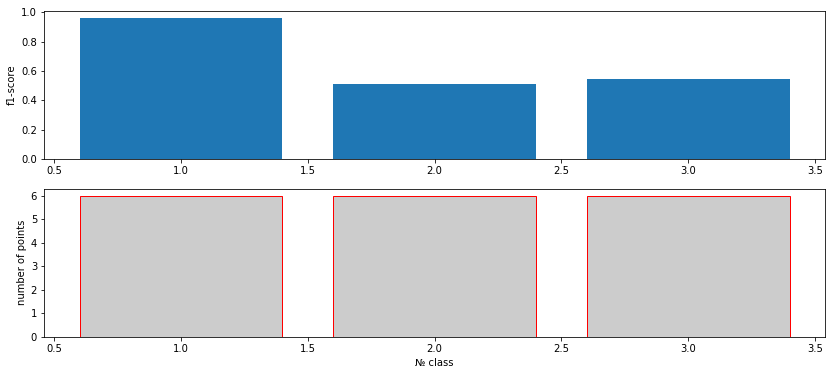

In [14]:
clf_meta = LogisticRegression(random_state=12345)
#clf_meta.fit(X_meta_trn, y_meta_trn-1)
#preds=clf_meta.predict_proba(X_meta_tst)
#[np.mean(my_f1_score(preds,y_meta_tst-1)),mean_prob0(preds,y_meta_tst-1)]

param_dist = {"C": np.arange(3, 10, 0.5),
              "solver": ['newton-cg','sag','saga','lbfgs'],
              "multi_class": ['ovr','multinomial','auto'],}

n_iter_search = 1000
rs_meta= RandomizedSearchCV( clf_meta,n_jobs=5, param_distributions=param_dist,
                                     n_iter=n_iter_search, cv=5, iid=False, random_state=12345)

start = time.time()
rs_meta.fit(X_meta_trn, y_meta_trn-1)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
clf_meta=rs_meta.best_estimator_
preds=clf_meta.predict_proba(X_meta_tst)
meta_score=np.mean([np.mean(my_f1_score(preds,y_meta_tst-1)),mean_prob0(preds,y_meta_tst-1)])

print('LogReg (MetaAlgo):')
print('\tf1-score (mean):\t' + str(np.mean(my_f1_score(preds,y_val1-1)).round(4)))
print('\tright probability:\t' + str(mean_prob0(preds,y_val1-1).round(4)))
fmeta_4plot=print_rez(preds,y_val1,n_class)

### Выводы:
###### 1. Идея работает: итоговое качество мета алгоритма лучше чем у каждого метода по отдельности
###### 2. Подход с подбором оптимальных параметров RandomizedSearchCV нужно менять: на малой выборке (120 образцов) этот подход еще работает, но на большой (32000) уже нет т.к. драматически увеличивается время расчета в кросс валидации.
###### 3. Выявлен самый ресурсоемкий метод - это Random Forest. (время расчета ~10 раз больше чем у остальных)
### Дальнейшие планы
###### 1. Вместо RandomizedSearchCV использовать простой цикл с подбором параметров но без крос валидации а с проверкой на отложенной (тестовой) выборке.
###### 2. Улучшить общее качество работы: На этапе предподготовки данных заменить псевдо-оптимальный выбор характерных скважин (центров подвыборок) на оптимальный. Поиск оптимальных осуществлять внутри каждого класса решая задачу кластеризации (в качестве X данных использовать матрицу взоимных растояний от каждой скважины до остальных).